In [ ]:
!pip install flwr-datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.9.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
!pip install flwr[simulation]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 40.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
  Attempting uninstall: typer
    Found existing installation: typer 0.15.3
    Uninstalling typer-0.15

In [ ]:
!pip install --upgrade cryptography==44.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 44.0.3
    Uninstalling cryptography-44.0.3:
      Successfully uninstalled cryptography-44.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.1 which is incompatible.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 44.0.1 which is incompatible.


In [ ]:
!pip install torchinfo

In [ ]:
# Standard libraries
import os
import shutil
import time
import json
from collections import Counter, OrderedDict
from typing import Dict, List, Tuple

# Third-party libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Compose
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torchinfo import summary

# Hugging Face datasets
from datasets import load_dataset, Dataset

# Flower
from flwr.client import NumPyClient, ClientApp
from flwr.common import NDArrays, Scalar, Context, Metrics, ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedOpt, FedProx
from flwr.simulation import run_simulation
from flwr_datasets.partitioner import Partitioner
from flwr_datasets.visualization import plot_label_distributions

# Kaggle (if used to pull data)
import kagglehub

In [ ]:
wsi_kpath = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")
xray_kpath = kagglehub.dataset_download("quynhlecl/lung-cancer-x-ray")

In [ ]:
def count_images_in_folders(root_dir, image_extensions=None):
    if image_extensions is None:
        # Common image file extensions
        image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}

    folder_image_counts = {}

    # Walk through directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Filter image files based on extension
        image_files = [f for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
        if image_files:
            folder_image_counts[dirpath] = len(image_files)

    return folder_image_counts

In [ ]:
def count_images(path):
    for folder, count in count_images_in_folders(path).items():
        print(f"Folder: {folder} - {count} images")

In [ ]:
def copy_image_dirs(src_root, dst_root, exclude_keywords=None, dry_run=True):
    if exclude_keywords is None:
        exclude_keywords = []

    for dirpath, dirnames, filenames in os.walk(src_root):
        # Skip excluded paths
        if any(keyword in dirpath for keyword in exclude_keywords):
            continue

        # Proceed only if folder has image files
        image_files = [f for f in filenames if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        if image_files:
            # Compute relative path and destination
            rel_path = os.path.relpath(dirpath, src_root)
            dst_path = os.path.join(dst_root, rel_path)

            if dry_run:
                print(f"[DRY RUN] Would copy:\n  From: {dirpath}\n  To:   {dst_path}\n")
            else:
                print(f"Copying:\n  From: {dirpath}\n  To:   {dst_path}")
                os.makedirs(dst_path, exist_ok=True)

                for f in image_files:
                    shutil.copy2(os.path.join(dirpath, f), os.path.join(dst_path, f))

In [ ]:
def rename_class_folders(root_dir, map, dry_run=True):
    for dirpath, dirnames, _ in os.walk(root_dir, topdown=False):
        for dirname in dirnames:
            original_path = os.path.join(dirpath, dirname)
            lower_name = dirname.lower()

            for keyword, new_name in map.items():
                if keyword in lower_name:
                    new_path = os.path.join(dirpath, new_name)

                    # Avoid renaming if destination already exists
                    if os.path.exists(new_path) and original_path != new_path:
                        i = 1
                        while os.path.exists(f"{new_path}_{i}"):
                            i += 1
                        new_path = f"{new_path}_{i}"

                    if dry_run:
                        print(f"[DRY RUN] Would rename:\n  {original_path}\n→ {new_path}")
                    else:
                        #print(f"Renaming:\n  {original_path}\n→ {new_path}")
                        os.rename(original_path, new_path)
                    break  # Only rename once per match

In [ ]:
def merge_subdirectories(source_dir, target_dir, dry_run=True):

    split_names = {'train', 'test', 'val', 'valid'}

    for subdir in os.listdir(source_dir):

        print(subdir)

        subdir_path = os.path.join(source_dir, subdir)
        if not os.path.isdir(subdir_path):
            continue

        subfolders = os.listdir(subdir_path)
        print(subfolders)
        if subdir.lower() in split_names:

            for class_name in subfolders:
                class_path = os.path.join(subdir_path, class_name)
                if not os.path.isdir(class_path):
                    continue

                dest_dir = os.path.join(target_dir, class_name)
                if dry_run:
                    print(f"[DRY RUN] Would create: {dest_dir}")
                else:
                    os.makedirs(dest_dir, exist_ok=True)

                for file in os.listdir(class_path):
                    src_file = os.path.join(class_path, file)
                    dst_file = os.path.join(dest_dir, file)

                    if os.path.exists(dst_file):
                        base, ext = os.path.splitext(file)
                        dst_file = os.path.join(dest_dir, f"{base}_{subdir}{ext}")

                    if dry_run:
                        print(f"[DRY RUN] Would move: {src_file} -> {dst_file}")
                    else:
                        shutil.move(src_file, dst_file)
        else:
            print("No splits")
            # No splits, assume it's just class folders directly (default to 'train')
            print(subdir_path)
            if not os.path.isdir(subdir_path):
                continue

            class_name = subdir
            class_path = subdir_path
            dest_dir = os.path.join(target_dir, class_name)
            if dry_run:
                print(f"[DRY RUN] Would create: {dest_dir}")
            else:
                os.makedirs(dest_dir, exist_ok=True)

            for file in os.listdir(class_path):
                src_file = os.path.join(class_path, file)
                dst_file = os.path.join(dest_dir, file)

                if os.path.exists(dst_file):
                    base, ext = os.path.splitext(file)
                    dst_file = os.path.join(dest_dir, f"{base}_{subdir}{ext}")

                if dry_run:
                    print(f"[DRY RUN] Would move: {src_file} -> {dst_file}")
                else:
                    shutil.move(src_file, dst_file)

        # Delete the original subdir
        if dry_run:
            print(f"[DRY RUN] Would delete: {subdir_path}")
        else:
            shutil.rmtree(subdir_path)

    # Delete the original dir
    if dry_run:
        print(f"[DRY RUN] Would delete: {source_dir}")
    else:
        shutil.rmtree(source_dir)

In [ ]:
count_images(wsi_kpath)

Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca - 5000 images
Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n - 5000 images
Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca - 5000 images
Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc - 5000 images
Folder: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n - 5000 images


In [ ]:
count_images(xray_kpath)

Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/chest_xray/val/Cancer - 8 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/chest_xray/val/NORMAL - 8 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/chest_xray/test/Cancer - 390 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/chest_xray/test/NORMAL - 234 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/chest_xray/train/Cancer - 3875 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/chest_xray/train/NORMAL - 1341 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/val/Cancer - 8 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/val/NORMAL - 8 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/test/Cancer - 390 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/test/NORMAL - 234 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/train/Cancer - 3875 images
Folder: /kaggle/input/lung-cancer-x-ray/chest_xra

In [ ]:
keywords_to_delete = ["chest_xray_lung/chest_xray"]  # Add or change as needed
copy_image_dirs(xray_kpath, "./datasets", keywords_to_delete, dry_run=False)

Copying:
  From: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/val/Cancer
  To:   ./datasets/chest_xray_lung/val/Cancer
Copying:
  From: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/val/NORMAL
  To:   ./datasets/chest_xray_lung/val/NORMAL
Copying:
  From: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/test/Cancer
  To:   ./datasets/chest_xray_lung/test/Cancer
Copying:
  From: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/test/NORMAL
  To:   ./datasets/chest_xray_lung/test/NORMAL
Copying:
  From: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/train/Cancer
  To:   ./datasets/chest_xray_lung/train/Cancer
Copying:
  From: /kaggle/input/lung-cancer-x-ray/chest_xray_lung/train/NORMAL
  To:   ./datasets/chest_xray_lung/train/NORMAL


In [ ]:
keywords_to_delete = ["lung_colon_image_set/colon_image_sets"]  # Add or change as needed
copy_image_dirs(wsi_kpath, "./datasets", keywords_to_delete, dry_run=False)

Copying:
  From: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca
  To:   ./datasets/lung_colon_image_set/lung_image_sets/lung_aca
Copying:
  From: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc
  To:   ./datasets/lung_colon_image_set/lung_image_sets/lung_scc
Copying:
  From: /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n
  To:   ./datasets/lung_colon_image_set/lung_image_sets/lung_n


In [ ]:
new_wsi_path = "./datasets/lung_colon_image_set/lung_image_sets/"

# Define your renaming map
rename_map = {
    'lung_aca': 'aca',
    'lung_n': 'n',
    'lung_scc': 'scc',
}

rename_class_folders(new_wsi_path, rename_map, dry_run=False)

In [ ]:
new_xray_path = "./datasets/chest_xray_lung/"

for name in ["test", "train", "val"]:

    root_dir = new_xray_path + name

    # Define your renaming map
    rename_map = {
        'normal': 'n',
        'cancer': 'c',
    }

    rename_class_folders(root_dir, rename_map, dry_run=False)  # Change to False to apply

In [ ]:
wsi_path = "./datasets/wsi/"
xray_path = "./datasets/xray/"
merge_subdirectories(new_wsi_path, wsi_path, dry_run=False)
merge_subdirectories(new_xray_path, xray_path, dry_run=False)

scc
['lungscc2112.jpeg', 'lungscc1289.jpeg', 'lungscc1132.jpeg', 'lungscc285.jpeg', 'lungscc3438.jpeg', 'lungscc1538.jpeg', 'lungscc3964.jpeg', 'lungscc2005.jpeg', 'lungscc2344.jpeg', 'lungscc202.jpeg', 'lungscc4800.jpeg', 'lungscc1274.jpeg', 'lungscc4939.jpeg', 'lungscc9.jpeg', 'lungscc80.jpeg', 'lungscc2756.jpeg', 'lungscc3443.jpeg', 'lungscc1726.jpeg', 'lungscc3087.jpeg', 'lungscc4824.jpeg', 'lungscc3828.jpeg', 'lungscc1083.jpeg', 'lungscc2706.jpeg', 'lungscc3182.jpeg', 'lungscc2115.jpeg', 'lungscc3979.jpeg', 'lungscc3997.jpeg', 'lungscc2713.jpeg', 'lungscc4084.jpeg', 'lungscc2236.jpeg', 'lungscc1954.jpeg', 'lungscc4419.jpeg', 'lungscc4637.jpeg', 'lungscc357.jpeg', 'lungscc1363.jpeg', 'lungscc1103.jpeg', 'lungscc1248.jpeg', 'lungscc2072.jpeg', 'lungscc909.jpeg', 'lungscc1317.jpeg', 'lungscc1443.jpeg', 'lungscc1078.jpeg', 'lungscc1842.jpeg', 'lungscc3386.jpeg', 'lungscc2690.jpeg', 'lungscc1386.jpeg', 'lungscc1630.jpeg', 'lungscc4685.jpeg', 'lungscc2845.jpeg', 'lungscc2262.jpeg', 'lun

In [ ]:
#shutil.rmtree('./datasets/chest_xray_lung')
#shutil.rmtree('./datasets/lung_colon_image_set')

# Federated Learning

## Util functions

In [ ]:
class MultiModalDataset(torch.utils.data.Dataset):
    def __init__(self, root, modalities, mapping=None, transform=None, input_size=64, use_cache=True):

        self.transform = transform
        self.input_size = input_size
        self.use_cache = use_cache
        self.cache = {}  # Dictionary for caching images
        self.samples = []
        self.mapping = mapping

        id = 0

        for i, mod in enumerate(modalities):
            mod_path = os.path.join(root, mod)
            print(mod_path)

            mod_dataset = ImageFolder(mod_path)

            if self.mapping != None:
                idx_to_class = {v: k for k, v in self.mapping.items()}

                # Rebuild samples list with new labels
                mod_dataset.samples = [
                    (path, self.mapping[classname])
                    for path, label in mod_dataset.samples
                    for classname in [mod_dataset.classes[label]]
                ]

                # Also update targets and class_to_idx
                mod_dataset.targets = [label for _, label in mod_dataset.samples]
                mod_dataset.class_to_idx = self.mapping
                mod_dataset.classes = [idx_to_class[i] for i in sorted(idx_to_class)]

            mod_samples = mod_dataset.samples  # List of (path, label)

            for path, label in tqdm(mod_samples):
                self.samples.append((path, label, i, id))  # 0 for modality 1

                if self.use_cache:

                    image = Image.open(path).convert("RGB")

                    if self.transform:
                        image = self.transform(image)
                    else:
                        image = transforms.ToTensor()(image)

                    self.cache[id] = image

                id += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label, modality_index, id = self.samples[idx]

        try:
            image = self.cache[id]
            #print("Cache hit")
        except KeyError:
            #print("Cache miss")
            image = self.transform(Image.open(path).convert("RGB"))

        zeros = torch.zeros(3, self.input_size, self.input_size)

        return tuple(
            image if i == modality_index else zeros for i, m in enumerate(modalities)
        ), label

In [ ]:
class ManualPartitioner(Partitioner):
    def __init__(self, partitions: Dict[int, list]):
        super().__init__()
        self.partitions = partitions  # Maps partition_id -> list of indices
        self._dataset: Dataset = None

    @property
    def num_partitions(self) -> int:
        return len(self.partitions)

    @property
    def dataset(self) -> Dataset:
        return self._dataset

    @dataset.setter
    def dataset(self, dataset: Dataset) -> None:
        if not isinstance(dataset, Dataset):
            raise TypeError("Only Hugging Face datasets.Dataset is supported.")
        self._dataset = dataset

    def load_partition(self, partition_id: int) -> Dataset:
        if self._dataset is None:
            raise ValueError("Dataset not assigned to the partitioner.")
        indices = self.partitions.get(partition_id)
        if indices is None:
            raise ValueError(f"No partition found for partition_id {partition_id}.")
        return self._dataset.select(indices)


In [ ]:
from torch.utils.data import Dataset

class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, ds, transform=None):
        self.dataset = hf_dataset
        self.cached_ds = ds

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        item = self.dataset[idx]

        raw_item = self.cached_ds[item['id']]

        return (raw_item[0], item["label"])

In [ ]:
torch.manual_seed(42)
g = torch.Generator()
g.manual_seed(42)

def get_dataloaders(dataset, batch_size: int = 32):

    partition_train_val = dataset.train_test_split(test_size=0.2, seed=42)

    train_dataset = HFDatasetWrapper(
        partition_train_val["train"], main_ds)
    val_dataset = HFDatasetWrapper(
        partition_train_val["test"], main_ds)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(
        train_dataset, batch_size=batch_size,
        shuffle=True, generator=g, num_workers=0)
    testloader = DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=0)

    return trainloader, testloader

In [ ]:
def train(net, id, trainloader, optimizer, device):

    criterion = nn.CrossEntropyLoss()
    net.to(device)
    net.train()
    running_loss = 0.0
    total = 0

    for images, labels in trainloader:
        images1, images2, labels = images[0].to(device), images[1].to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images1, images2, id)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        running_loss += loss.item()

    return running_loss / len(trainloader)

def test(net, id, testloader, device):
    """Validate the network on the entire test set."""
    criterion = nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images1, images2, labels = images[0].to(device), images[1].to(device), labels.to(device)
            outputs = net(images1, images2, id)

            loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return loss / len(testloader), accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNNBranch(nn.Module):
    def __init__(self):
        super(SimpleCNNBranch, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape: (128, 1, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # Flatten to (batch_size, 128)

class MultiModalityMultiHeadCNN(nn.Module):
    def __init__(self, output_dim_1, output_dim_2):
        super(MultiModalityMultiHeadCNN, self).__init__()

        self.branch1 = SimpleCNNBranch()
        self.branch2 = SimpleCNNBranch()

        # More expressive shared layers
        self.shared_fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.LayerNorm(256),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.LayerNorm(128)
        )

        # Task-specific heads
        self.head1 = nn.Linear(128, output_dim_1)
        self.head2 = nn.Linear(128, output_dim_2)

    def forward(self, x1, x2, task_id: int):
        if x1.abs().sum() > 0:
            features = self.branch1(x1)
        elif x2.abs().sum() > 0:
            features = self.branch2(x2)
        else:
            raise ValueError("No modality provided")

        shared = self.shared_fc(features)

        if task_id == 0:
            return self.head1(shared)
        elif task_id == 1:
            return self.head2(shared)
        else:
            raise ValueError("Invalid task_id")

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader, id) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.id = id
        self.model = MultiModalityMultiHeadCNN(
            output_dim_1=3, output_dim_2=2)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.head_path = os.path.join('heads/', str(id) + ".pth")
        self.load_head()

    def fit(self, parameters, config):

        set_params(self.model, parameters)
        optim = torch.optim.Adam(self.model.parameters(), lr=0.001)
        train(self.model, self.id, self.trainloader, optim, self.device)

        self.save_head()

        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):

        set_params(self.model, parameters)
        loss, accuracy = test(self.model, self.id, self.valloader, self.device)

        return float(loss), len(self.valloader), {"accuracy": accuracy, "loss": loss, 'id': self.id}

    def save_head(self):
        head_state_dict = {k: v.cpu() for k, v in self.model.state_dict().items() if k.startswith("head")}
        torch.save(head_state_dict, self.head_path)

    def load_head(self):
        if os.path.exists(self.head_path):
            head_state_dict = torch.load(self.head_path)
            model_state = self.model.state_dict()
            model_state.update(head_state_dict)
            self.model.load_state_dict(model_state, strict=False)

def set_params(model, parameters):
    keys = [k for k in model.state_dict().keys() if not k.startswith("head")]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict()
    for k, v in params_dict:
        state_dict[k] = torch.from_numpy(v)
    model.load_state_dict(state_dict, strict=False)  # strict=False allows partial loading


def get_params(model):
    return [val.cpu().numpy() for k, val in model.state_dict().items() if not k.startswith("head")]

In [ ]:
def client_fn(context: Context):
    """Returns a FlowerClient containing its data partition."""

    partition_id = int(context.node_config["partition-id"])
    partition = partitioner.load_partition(partition_id)
    trainloader, testloader = get_dataloaders(partition, batch_size=32)

    return FlowerClient(trainloader=trainloader, valloader=testloader, id=partition_id).to_client()

client_app = ClientApp(client_fn=client_fn)

In [ ]:
from datetime import datetime

client_metrics = []

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    client_metrics.append(metrics)
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]

    acc = [(m[1]['id'], m[1]['accuracy'], m[1]['loss']) for m in metrics]
    acc = sorted(acc, key=lambda x: x[0])
    print(datetime.now().strftime("%H:%M:%S"))
    for x in acc:
        print(x)
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
def plot_metrics(client_metrics, strat='FedAvg', num_rounds=50):

    client_accs = [[] for _ in range(len(client_metrics[0]))]  # List of lists to store accuracies for each client
    client_losses = [[] for _ in range(len(client_metrics[0]))]  # List of lists to store losses for each client

    # Loop through each round of experiment (outer list)
    for round_data in client_metrics:
        # Loop through each client (inner list)
        for client_idx, (_, metrics) in enumerate(round_data):
            # Append the accuracy and loss for the current client in this round
            client_accs[metrics['id']].append(metrics['accuracy'])
            client_losses[metrics['id']].append(metrics['loss'])

    for i, client in enumerate(client_accs):
        plt.plot(client, label='client ' + str(i))
    plt.title(f"{strat} ({num_rounds} rounds)")
    plt.xlabel("Iteration")
    plt.ylabel("Acc")
    plt.ylim([0.6, 1.0])
    plt.legend()
    plt.show()

In [ ]:
def dual_plot(img1, img2):
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    axs[0].imshow(img1)
    axs[0].set_title(f"Image {0}")
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(f"Image {15001}")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def reset_heads():
    head_path = './heads/'
    if os.path.exists(head_path):
        shutil.rmtree(head_path)
    os.makedirs(head_path, exist_ok=True)

In [113]:
def serialize(metrics):
    return [
        {
            '0': m[0][1]['accuracy'],
            '1': m[1][1]['accuracy'],
            'avg': sum(w * clt['accuracy'] for w, clt in m) / sum(w for w, _ in m)
        } for m in metrics
    ]

## Experiment

In [ ]:
# backend configuration

backend_config = {
    "client_resources": {
        "num_gpus": 1.0,
        "num_cpus": 8.0},
    "äctor": {
        "actor_reuse": False
    }
}

In [ ]:
# folder with images
root = "./datasets"
count_images(root)

Folder: ./datasets/wsi/scc - 5000 images
Folder: ./datasets/wsi/n - 5000 images
Folder: ./datasets/wsi/aca - 5000 images
Folder: ./datasets/xray/n - 1583 images
Folder: ./datasets/xray/c - 4273 images


In [ ]:
# modality and transform configuration

dataset_path = './datasets'

modalities = [
    'wsi',
    'xray'
]

modalities_path = [os.path.join(dataset_path, i) for i in modalities]

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# dataset configuration for partitioning
mapping = None

main_ds = MultiModalDataset(
    dataset_path,
    modalities,
    transform=transform,
    mapping=mapping,
    use_cache=True)

main_ds.__len__()

modality_map = [modality for _, _, modality, _ in main_ds.samples]
modality_map_dict = {idx: modality for idx, (_, _, modality, _) in enumerate(main_ds.samples)}
manual_partitions = {}

for i, mod in enumerate(modalities):
    manual_partitions[i] = [j for j, m in modality_map_dict.items() if m == i]

for key, value in manual_partitions.items():
    print(f"{key}: {len(value)}")

./datasets/wsi


100%|██████████| 15000/15000 [01:22<00:00, 181.05it/s]


./datasets/xray


100%|██████████| 5856/5856 [01:15<00:00, 77.49it/s]

0: 15000
1: 5856


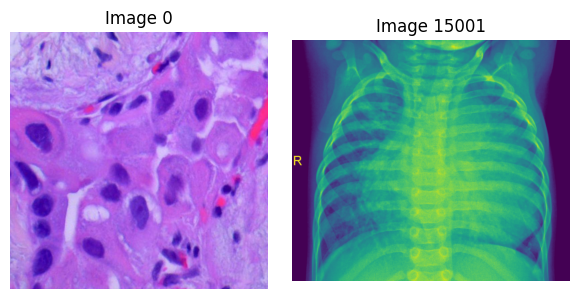

In [ ]:
img1 = Image.open(main_ds.samples[0][0])
img2 = Image.open(main_ds.samples[15001][0])

dual_plot(img1, img2)

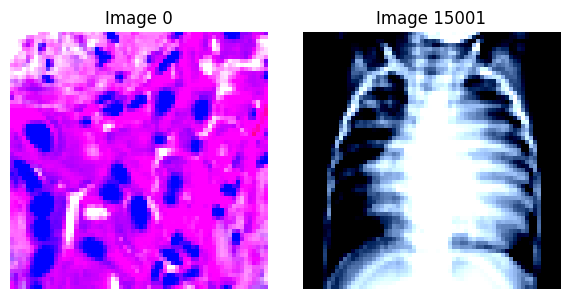

In [ ]:
# Extract and prepare images
img1 = main_ds[0][0][0].permute(1, 2, 0).cpu().numpy()
img2 = main_ds[15001][0][1].permute(1, 2, 0).cpu().numpy()

dual_plot(img1, img2)

/usr/local/lib/python3.11/dist-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


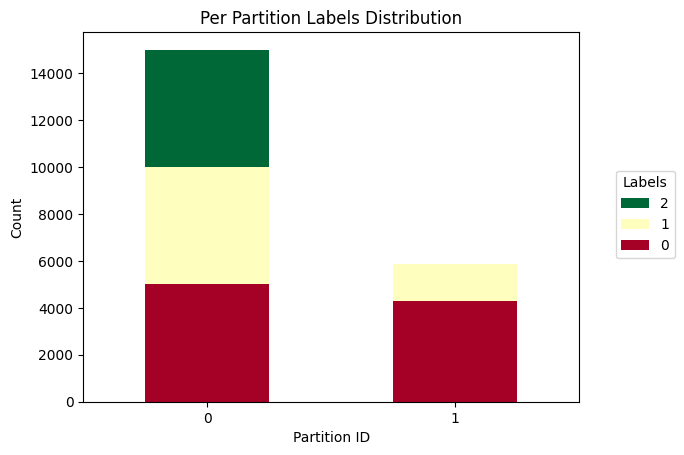

In [ ]:
from datasets import Dataset

data = []

for path, label, modality, id in main_ds.samples:
    data.append({
        "image": path,
        "label": label,
        "modality": modality,
        "id": id
    })

df = pd.DataFrame(data)
hf_dataset = Dataset.from_pandas(df)

partitioner = ManualPartitioner(partitions=manual_partitions)
partitioner.dataset = hf_dataset

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,
    title="Per Partition Labels Distribution",
)

In [ ]:
# Model
aux_model = MultiModalityMultiHeadCNN(output_dim_1=4, output_dim_2=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
aux_model.to(device)
x1 = torch.randn(1, 3, 64, 64).to(device)
x2 = torch.randn(1, 3, 64, 64).to(device)
task_id = 1
summary(aux_model, input_data=(x1, x2, task_id))

Layer (type:depth-idx)                   Output Shape              Param #
MultiModalityMultiHeadCNN                [1, 3]                    93,764
├─SimpleCNNBranch: 1-1                   [1, 128]                  --
│    └─Sequential: 2-1                   [1, 128, 1, 1]            --
│    │    └─Conv2d: 3-1                  [1, 32, 64, 64]           896
│    │    └─ReLU: 3-2                    [1, 32, 64, 64]           --
│    │    └─MaxPool2d: 3-3               [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           18,496
│    │    └─ReLU: 3-5                    [1, 64, 32, 32]           --
│    │    └─MaxPool2d: 3-6               [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-7                  [1, 128, 16, 16]          73,856
│    │    └─ReLU: 3-8                    [1, 128, 16, 16]          --
│    │    └─AdaptiveAvgPool2d: 3-9       [1, 128, 1, 1]            --
├─Sequential: 1-2                        [1, 128]                  --
│ 

In [ ]:
# FedAvg strategy
reset_heads()

num_rounds = 50
client_metrics = []

def server_fn(context: Context):

    model = MultiModalityMultiHeadCNN(output_dim_1=3, output_dim_2=2)
    ndarrays = get_params(model)

    global_model_init = ndarrays_to_parameters(ndarrays)

    strategy = FedAvg(
       fraction_fit=1.0, fraction_evaluate=1.0,
       evaluate_metrics_aggregation_fn=weighted_average,
       initial_parameters=global_model_init,
    )

    config = ServerConfig(num_rounds=num_rounds)

    return ServerAppComponents(strategy=strategy, config=config)

server_app = ServerApp(server_fn=server_fn)

run_simulation(
    client_app=client_app, server_app=server_app, num_supernodes=2,
    backend_config=backend_config
)

fedavg_metrics = client_metrics[:]

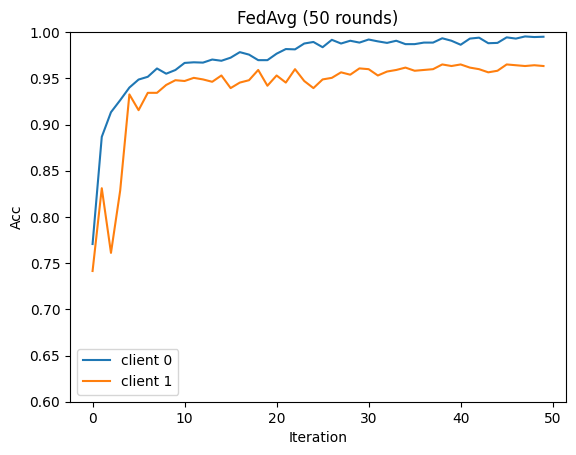

In [ ]:
plot_metrics(fedavg_metrics, strat='FedAvg', num_rounds=num_rounds)

In [ ]:
# FedOpt strategy
reset_heads()

num_rounds = 50
client_metrics = []

def server_fn(context: Context):

    model = MultiModalityMultiHeadCNN(output_dim_1=3, output_dim_2=2)
    ndarrays = get_params(model)

    global_model_init = ndarrays_to_parameters(ndarrays)

    strategy = FedOpt(
       fraction_fit=1.0, fraction_evaluate=1.0,
       eta=0.1, eta_l=0.1, beta_1=0.9, beta_2=0.99,
       evaluate_metrics_aggregation_fn=weighted_average,
       initial_parameters=global_model_init,
    )

    config = ServerConfig(num_rounds=num_rounds)

    return ServerAppComponents(strategy=strategy, config=config)

server_app = ServerApp(server_fn=server_fn)

run_simulation(
    client_app=client_app, server_app=server_app, num_supernodes=2,
    backend_config=backend_config
)

fedopt_metrics = client_metrics[:]

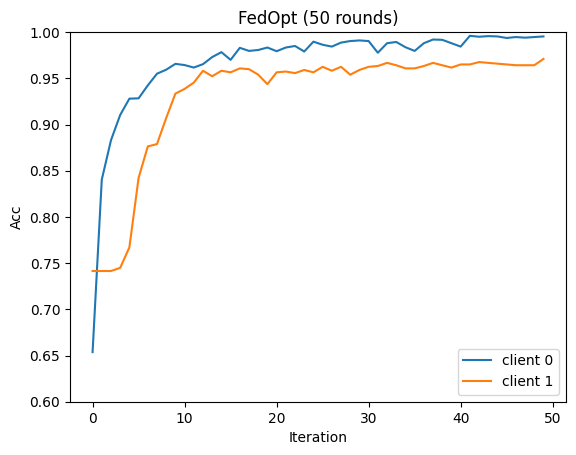

In [ ]:
plot_metrics(fedopt_metrics, strat='FedOpt', num_rounds=num_rounds)

In [ ]:
# FedProx strategy
reset_heads()

num_rounds = 50
client_metrics = []

def server_fn(context: Context):

    model = MultiModalityMultiHeadCNN(output_dim_1=3, output_dim_2=2)
    ndarrays = get_params(model)

    global_model_init = ndarrays_to_parameters(ndarrays)

    strategy = FedProx(
        fraction_fit=1.0, fraction_evaluate=1.0, proximal_mu=0.1,
        evaluate_metrics_aggregation_fn=weighted_average,
        initial_parameters=global_model_init,
    )

    config = ServerConfig(num_rounds=num_rounds)

    return ServerAppComponents(strategy=strategy, config=config)

server_app = ServerApp(server_fn=server_fn)

run_simulation(
    client_app=client_app, server_app=server_app, num_supernodes=2,
    backend_config=backend_config
)

fedprox_metrics = client_metrics[:]

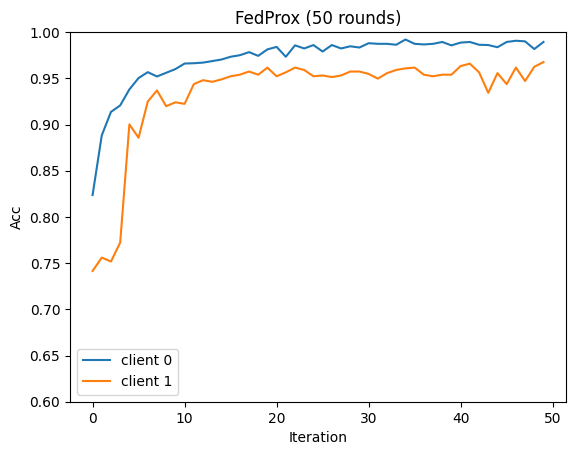

In [ ]:
plot_metrics(fedprox_metrics, strat='FedProx', num_rounds=num_rounds)

In [115]:
import json

fedavg_serialized = serialize(fedavg_metrics)
fedopt_serialized = serialize(fedopt_metrics)
fedprox_serialized = serialize(fedprox_metrics)

to_save = {
    'fedavg': fedavg_serialized,
    'fedopt': fedopt_serialized,
    'fedprox': fedprox_serialized
}

with open('fed_metrics.json', 'w') as f:
    json.dump(to_save, f)

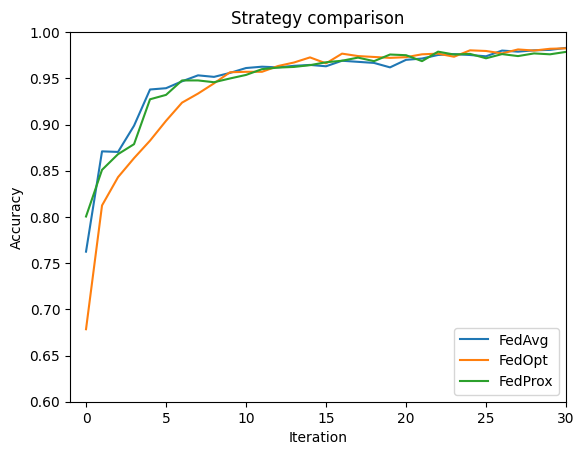

In [121]:
plt.plot([m['avg'] for m in fedavg_serialized], label='FedAvg')
plt.plot([m['avg'] for m in fedopt_serialized], label='FedOpt')
plt.plot([m['avg'] for m in fedprox_serialized], label='FedProx')
plt.title("Strategy comparison")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim([0.6, 1.0])
plt.xlim([-1, 30])
plt.legend()
plt.show()